row number: 5574


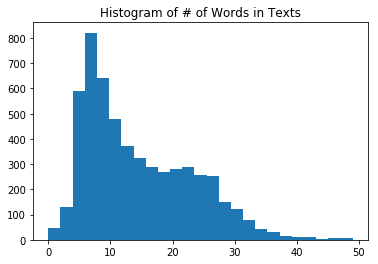

word number: 2108
Training Observation #10: Loss = 2.683585
Training Observation #20: Loss = 3.7168089e-09
Training Observation #30: Loss = 7.2234506e-08
Training Observation #40: Loss = 5.906923e-11
Training Observation #50: Loss = 1.6363895e-12
Training Observation #60: Loss = 4.716981e-10
Training Observation #70: Loss = 3.7705616e-09
Training Observation #80: Loss = 0.00023534428
Training Observation #90: Loss = 0.025592238
Training Observation #100: Loss = 0.040137112
Training Observation #110: Loss = 6.0292343e-10
Training Observation #120: Loss = 7.466367e-05
Training Observation #130: Loss = 3.3807182e-06
Training Observation #140: Loss = 0.28463215
Training Observation #150: Loss = 4.5426008e-05
Training Observation #160: Loss = 0.0021138366
Training Observation #170: Loss = 3.7154693e-09
Training Observation #180: Loss = 1.7788092e-09
Training Observation #190: Loss = 3.9077559
Training Observation #200: Loss = 9.997589e-06
Training Observation #210: Loss = 5.364425e-10
Train

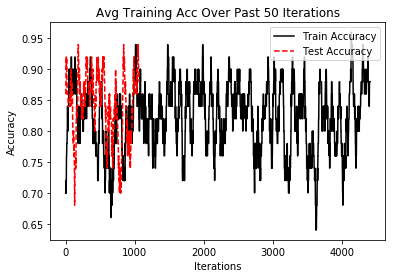

In [19]:
# 7-2 recipe 42
## BoW model(文章中の単語をそのまま情報量として使う)
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import csv
import string
import requests
import io
from zipfile import ZipFile
from tensorflow.contrib import learn
from tensorflow.python.framework import ops

ops.reset_default_graph()
sess = tf.Session()

# load data
save_file_name = os.path.join('data', 'temp_spam_data.csv')

if not os.path.exists('temp'):
    os.makedirs('temp')

if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')   
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]

    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

print('row number: ' + str(len(text_data)))
    
# 0: ham or spam flag, 1: title
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]
target = [1 if x == 'spam' else 0 for x in target]

# extract text
## change to lower text
texts = [x.lower() for x in texts]
## delete ','
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]
## delete 'number'
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]
## delete ' '
texts = [' '.join(x.split()) for x in texts]

# plot length of text by hist
text_lengths = [len(x.split()) for x in texts]
text_lengths = [x for x in text_lengths if x < 50]
plt.hist(text_lengths, bins = 25)
plt.title('Histogram of # of Words in Texts')
plt.show()

# split data to train-data and test-data
train_indices = np.random.choice(len(texts), round(len(texts)*0.8),
                                     replace=False)
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

# set parameter for tuning BOW
sentence_size = 25
min_word_freq = 3

# prepear word vector for Word Embbeding
## restrict word number of text to 25 words
vocab_processor = learn.preprocessing.VocabularyProcessor(
    sentence_size, min_frequency = min_word_freq)
vocab_processor.fit_transform(texts)
embedding_size = len(vocab_processor.vocabulary_)
print("word number: " + str(embedding_size))

# define variables and placeholder
A = tf.Variable(tf.random_normal(shape = [embedding_size, 1]))
b = tf.Variable(tf.random_normal(shape = [1, 1]))

x_data = tf.placeholder(shape = [sentence_size], dtype = tf.int32)
y_target = tf.placeholder(shape = [1, 1], dtype = tf.float32)

# change index-array to one-hot vector
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))
## change word to vector (25 size/ sentence -> about 2000)
x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
x_cols_sums = tf.reduce_sum(x_embed, 0)

# define model(y = A * x + b: 2000(ex: You have the meeting.) -> 1(ex: 'ham'))
x_col_sums_2D = tf.expand_dims(x_cols_sums, 0)
model_output = tf.add(tf.matmul(x_col_sums_2D, A), b)
prediction = tf.sigmoid(model_output)

# define loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits = model_output, labels = y_target))

# define optimization function
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

# initlize
init = tf.global_variables_initializer()
sess.run(init)

# update variables
loss_vec = []
train_acc_all = []
train_acc_avg = []
## turn count of train's sentence times
for ix, t in enumerate(vocab_processor.fit_transform(texts_train)):
    y_data = [[target_train[ix]]]
    sess.run(train_step, feed_dict = {x_data: t, y_target: y_data})
    
    temp_loss = sess.run(loss, feed_dict = {x_data: t, y_target: y_data})
    loss_vec.append(temp_loss)
    
    if (ix+1)%10==0:
        print('Training Observation #' + str(ix+1) + ': Loss = ' + str(temp_loss))

    # 正解率の移動平均を追跡
    ## 1つの観測の予測値を取得
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data: t, y_target: y_data})
    ## 予測が正解かどうかを真偽値で取得
    train_acc_temp = target_train[ix]==np.round(temp_pred)
    train_acc_all.append(train_acc_temp)
    if len(train_acc_all) >= 50:
        train_acc_avg.append(np.mean(train_acc_all[-50:]))
        
test_acc_all = []
test_acc_avg = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_test)):
    y_data = [[target_test[ix]]]
    if (ix+1)%50 == 0:
        print('Test Observation #' + str(ix+1))
    
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data: t, y_target: y_data})
    
    test_acc_temp = target_test[ix]==np.round(temp_pred)
    test_acc_all.append(test_acc_temp)
    if len(test_acc_all) >= 50:
        test_acc_avg.append(np.mean(test_acc_all[-50:]))

#    print('\nOverall Test Accuracy: {}'.format(np.mean(test_acc_all)))
    
plt.plot(range(len(train_acc_avg)), train_acc_avg, 'k-', label='Train Accuracy')
plt.plot(range(len(test_acc_avg)), test_acc_avg, 'r--', label='Test Accuracy')
plt.title('Avg Training Acc Over Past 50 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

In [21]:
# test vocabularyprocessor 

import numpy as np
from tensorflow.contrib import learn

x_text = ['This is a cat','This must be boy', 'This is a a dog']
#max_document_length = max([len(x.split(" ")) for x in x_text])
# test: restrict word number in text
max_document_length = 3

## Create the vocabularyprocessor object, setting the max lengh of the documents.
vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)

## Transform the documents using the vocabulary.
x = np.array(list(vocab_processor.fit_transform(x_text)))    

## Extract word:id mapping from the object.
vocab_dict = vocab_processor.vocabulary_._mapping

## Sort the vocabulary dictionary on the basis of values(id).
## Both statements perform same task.
#sorted_vocab = sorted(vocab_dict.items(), key=operator.itemgetter(1))
sorted_vocab = sorted(vocab_dict.items(), key = lambda x : x[1])

## Treat the id's as index into list and create a list of words in the ascending order of id's
## word with id i goes at index i of the list.
vocabulary = list(list(zip(*sorted_vocab))[0])

print(vocabulary)
print(x)

['<UNK>', 'This', 'is', 'a', 'cat', 'must', 'be', 'boy', 'dog']
[[1 2 3]
 [1 5 6]
 [1 2 3]]


row number: 5574


/Users/tomo_will/.pyenv/versions/3.5.0/envs/sandbox350/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


1000
Generation # 500. Train Loss (Test Loss): 0.55 (0.57). Train Acc (Test Acc): 0.76 (0.71)
Generation # 1000. Train Loss (Test Loss): 0.50 (0.53). Train Acc (Test Acc): 0.80 (0.75)
Generation # 1500. Train Loss (Test Loss): 0.57 (0.51). Train Acc (Test Acc): 0.76 (0.78)
Generation # 2000. Train Loss (Test Loss): 0.49 (0.49). Train Acc (Test Acc): 0.83 (0.80)
Generation # 2500. Train Loss (Test Loss): 0.41 (0.48). Train Acc (Test Acc): 0.86 (0.81)
Generation # 3000. Train Loss (Test Loss): 0.44 (0.48). Train Acc (Test Acc): 0.83 (0.82)
Generation # 3500. Train Loss (Test Loss): 0.43 (0.48). Train Acc (Test Acc): 0.84 (0.82)
Generation # 4000. Train Loss (Test Loss): 0.42 (0.47). Train Acc (Test Acc): 0.88 (0.83)
Generation # 4500. Train Loss (Test Loss): 0.42 (0.47). Train Acc (Test Acc): 0.83 (0.83)
Generation # 5000. Train Loss (Test Loss): 0.46 (0.47). Train Acc (Test Acc): 0.84 (0.83)
Generation # 5500. Train Loss (Test Loss): 0.35 (0.47). Train Acc (Test Acc): 0.88 (0.83)
Genera

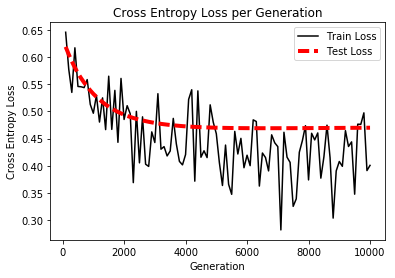

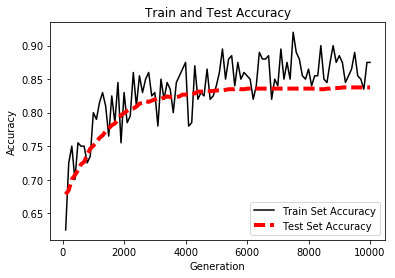

In [25]:
# 7-3 recipe 43
## TF-IDF（出現単語の頻度を考慮して重み付けを行う、全体での出現頻度が少ないが、
## ある文章中の出現頻度が高い場合には、重みを高くする。）
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import os
import string
import requests
import io
import nltk
from zipfile import ZipFile
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.python.framework import ops

ops.reset_default_graph()
sess = tf.Session()

batch_size = 200
max_features = 1000

# load data
save_file_name = os.path.join('data', 'temp_spam_data.csv')

if not os.path.exists('temp'):
    os.makedirs('temp')

if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]

    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

print('row number: ' + str(len(text_data)))

# 0: ham or spam flag, 1: title
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]
target = [1. if x == 'spam' else 0. for x in target]

# extract text
## change to lower text
texts = [x.lower() for x in texts]
## delete ','
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]
## delete 'number'
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]
## delete ' '
texts = [' '.join(x.split()) for x in texts]

# tokenize(ex: This is a cat. -> This/is/a/cat)
def tokenizer(text):
    words = nltk.word_tokenize(text)
    return words

# create tfidf
## TfidfVectorizer + fit_transform(ex: This is a cat. -> [ 0.4 0.77 0.49 0.45] )
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = 'english', max_features = max_features)
sparse_tfidf_texts = tfidf.fit_transform(texts)
## sparse matrix -> normal matrix(toarray:numpy.ndarray. todense:numpy.matrix)
print(len(sparse_tfidf_texts.toarray()[0]))

# split data to train-data and test-data
train_indices = np.random.choice(sparse_tfidf_texts.shape[0],
                                 round(sparse_tfidf_texts.shape[0]*0.8),
                                 replace=False)
test_indices = np.array(list(set(range(sparse_tfidf_texts.shape[0])) - set(train_indices)))
texts_train = sparse_tfidf_texts[train_indices]
texts_test = sparse_tfidf_texts[test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

# define variables and placeholder
A = tf.Variable(tf.random_normal(shape = [max_features, 1]))
b = tf.Variable(tf.random_normal(shape = [1, 1]))

x_data = tf.placeholder(shape = [None, max_features], dtype = tf.float32)
y_target = tf.placeholder(shape = [None, 1], dtype = tf.float32)

# define model (y = A * x + b)
model_output = tf.add(tf.matmul(x_data, A), b)
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

# define loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits = model_output, labels = y_target))

# define optimization function
my_opt = tf.train.GradientDescentOptimizer(0.0025)
train_step = my_opt.minimize(loss)

# initialize
init = tf.global_variables_initializer()
sess.run(init)

# update variables
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(texts_train.shape[0], size = batch_size)
    rand_x = texts_train[rand_index].todense()
    rand_y = np.transpose([target_train[rand_index]])
    sess.run(train_step, feed_dict = {x_data: rand_x, y_target: rand_y})
    
    if (i+1)%100 == 0:
        i_data.append(i+1)
        train_loss_temp = sess.run(loss, feed_dict={
            x_data: rand_x,
            y_target: rand_y
        })
        train_loss.append(train_loss_temp)

        test_loss_temp = sess.run(loss, feed_dict={
            x_data: texts_test.todense(),
            y_target: np.transpose([target_test])
        })
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict={
            x_data: rand_x,
            y_target: rand_y
        })
        train_acc.append(train_acc_temp)
        
        test_acc_temp = sess.run(accuracy, feed_dict={
            x_data: texts_test.todense(),
            y_target: np.transpose([target_test])
        })
        test_acc.append(test_acc_temp)

    if (i+1)%500 == 0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). '
             'Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

# 損失値をプロット
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()
# 正解率をプロット
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [39]:
# 7-4 recipe 44
## skipgram（単語の順序も考慮して、単語から前後の単語を予測する）
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import string
import requests
import collections
import io
import tarfile
import urllib.request
from nltk.corpus import stopwords
from tensorflow.python.framework import ops

ops.reset_default_graph()
sess = tf.Session()

# set parameter
batch_size = 100
embedding_size = 200
vocabulary_size = 10000
generations = 100000
num_sampled = int(batch_size / 2)
window_size = 5

## paramete for print
print_loss_every = 1000

stops = stopwords.words('english')

# settinct for test
print_valid_every = 5000
valid_words = ['cliche', 'love', 'hate', 'silly', 'sad']

#os.chdir(os.path.dirname(os.path.realpath(__file__)))
def load_movie_data():
    save_folder_name = 'data'
    pos_file = os.path.join(save_folder_name, 'rt-polaritydata', 'rt-polarity.pos')
    neg_file = os.path.join(save_folder_name, 'rt-polaritydata', 'rt-polarity.neg')

    if not os.path.exists(os.path.join(save_folder_name, 'rt-polaritydata')):
        movie_data_url = 'http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz'

        req = requests.get(movie_data_url, stream=True)
        with open(os.path.join(save_folder_name, 'temp_movie_review_temp.tar.gz'), 'wb') as f:
            for chunk in req.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
                    f.flush()

        tar = tarfile.open(os.path.join(save_folder_name, 'temp_movie_review_temp.tar.gz'), "r:gz")
        tar.extractall(path='data')
        tar.close()
    pos_data = []
    with open(pos_file, 'r', encoding='latin-1') as f:
        for line in f:
            pos_data.append(line.encode('ascii', errors='ignore').decode())
    f.close()
    pos_data = [x.rstrip() for x in pos_data]
    neg_data = []
    with open(neg_file, 'r', encoding='latin-1') as f:
        for line in f:
            neg_data.append(line.encode('ascii', errors='ignore').decode())
    f.close()
    neg_data = [x.rstrip() for x in neg_data]
    texts = pos_data + neg_data
    target = [1]*len(pos_data) + [0]*len(neg_data)
    
    return(texts, target)

texts, target = load_movie_data()

def normalize_text(texts, stops):
    # 小文字に変換
    texts = [x.lower() for x in texts]
    # 句読点を削除
    texts = [''.join(c for c in x if c not in string.punctuation)
                 for x in texts]
    # 数字を削除
    texts = [''.join(c for c in x if c not in '0123456789') for x in texts]
    # ストップワードを削除
    texts = [' '.join([word for word in x.split() if word not in (stops)])
                 for x in texts]
    # 余分なホワイトスペースを削除
    texts = [' '.join(x.split()) for x in texts]
    return(texts)

texts = normalize_text(texts, stops)

target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > 2]
texts = [x for x in texts if len(x.split()) > 2]

# output {word: word_count}
def build_dictionary(sentences, vocabulary_size):
    split_sentences = [s.split() for s in sentences]
    words = [x for sublist in split_sentences for x in sublist]
    
    count = [['RARE', -1]]
    
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    
    word_dict = {}
    
    for word, word_count in count:
        word_dict[word] = len(word_dict)

    return(word_dict)

# change word to index
def text_to_numbers(sentences, word_dict):
    data = []
    for sentence in sentences:
        sentence_data = []
        for word in sentence.split(' '):
            if word in word_dict:
                word_ix = word_dict[word]
            else:
                word_ix = 0
            sentence_data.append(word_ix)
        data.append(sentence_data)
    return(data)

word_dictionary = build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_to_numbers(texts, word_dictionary)

valid_examples = [word_dictionary[x] for x in valid_words]

(todo)